# Procesamiento de Imágenes Nocturnas

Este proyecto implementa técnicas de mejora y preprocesamiento de imágenes capturadas en condiciones de baja iluminación, aplicando ajustes de histograma, ecualización adaptativa y filtrado para mejorar la visibilidad y calidad de las imágenes obtenidas por cámaras de seguridad nocturnas.



## Objetivo

Este proyecto procesa imágenes obtenidas por una cámara de seguridad nocturna, aplicando técnicas de procesamiento de imagen para mejorar la calidad y visibilidad de las imágenes de entrada.



## Configuración del Entorno

Se configuran las bibliotecas necesarias para el procesamiento de imágenes y visualización de resultados.



In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from skimage import data, io, filters
from skimage.color import rgb2gray

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import importlib
import sys
from os.path import join

# Configuración de directorio base
# Si se ejecuta en Google Colab, descomentar y configurar la ruta correspondiente
google_colab = False

if google_colab:
    drive = importlib.import_module('google.colab.drive')
    drive.mount('/content/drive')
    sys.path.insert(0, '/content/drive/MyDrive/computer-vision/procesamiento_imagenes_nocturnas')
    dir_base = "/content/drive/MyDrive/computer-vision/procesamiento_imagenes_nocturnas"
else:
    dir_base = "./"

In [4]:
def plot_histogram(img):
    from matplotlib import pyplot as plt
    n_dimensiones = len(img.shape)
    if n_dimensiones == 2: # Solo X,Y
        img_int = 255 * img.flatten()
        plt.hist(img_int, bins = np.arange(256), color="darkgrey")
        plt.title("Gray scale histogram")
    elif n_dimensiones == 3: # X,Y y Canal
        if img.shape[2] == 3: # R,G,B
            img_r = img[:,:,0].flatten()
            img_g = img[:,:,1].flatten()
            img_b = img[:,:,2].flatten()

            if img.dtype == np.dtype('uint8'):
                plt.hist(img_r, bins = np.arange(256), color = "red")
                plt.hist(img_g, bins = np.arange(256), color = "green")
                plt.hist(img_b, bins = np.arange(256), color = "blue")
            else:
                plt.hist(img_r, bins = np.arange(1, step=1/255), color = "red")
                plt.hist(img_g, bins = np.arange(1, step=1/255), color = "green")
                plt.hist(img_b, bins = np.arange(1, step=1/255), color = "blue")

            plt.title("Color histogram")
    plt.show()

## Flujo de Procesamiento

### Carga de Imagen

Se carga la imagen de entrada desde el archivo `"img/1.jpg"` en memoria para su procesamiento.



In [5]:
img = imageio.imread(join(dir_base, "img/1.jpg"))

### Se analizan las dimensiones de la imagen y se identifica el espacio de color en el que se encuentra para comprender la estructura de los datos.



In [6]:
print(f"Dimensiones: {img.shape}")
print(f"Espacio de color: {'RGB' if img.shape[2] == 3 else 'Grayscale'}")

Dimensiones: (2848, 4256, 3)
Espacio de color: RGB


### Visualización de la Imagen Original

Se muestra la imagen original en pantalla para evaluar su estado inicial.



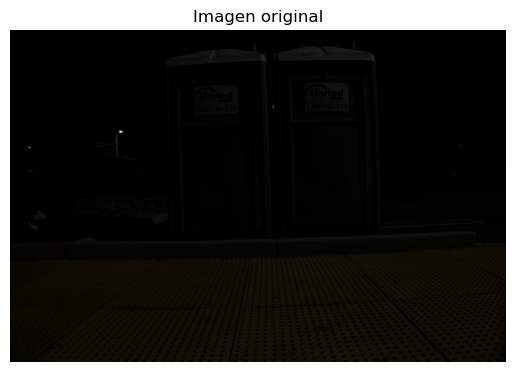

In [7]:
plt.imshow(img)
plt.title("Imagen original")
plt.axis('off')
plt.show()

### Evaluación Inicial

Se evalúa el contenido visible en la imagen. En condiciones de baja iluminación, la imagen puede requerir ajustes para apreciar claramente su contenido.



In [ ]:
"""

No se aprecia claramente lo que contiene la imagen sin realizar ajustes de iluminación, ya que parece ser una 
foto nocturna con baja luminosidad.

"""


### Análisis de Histograma

Se genera el histograma de la imagen y se describe la distribución de intensidades de píxeles para comprender las características de iluminación.



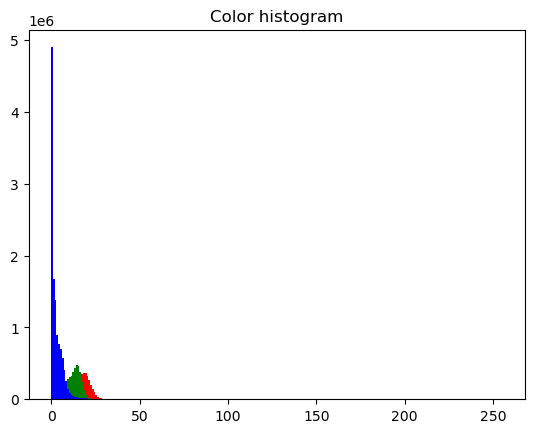

In [8]:
plot_histogram(img)

### Mejora de la Imagen mediante Ecualización Adaptativa

Para mejorar la visibilidad de la imagen nocturna, se aplica ecualización adaptativa del histograma. Esta técnica redistribuye las intensidades de píxeles de manera local, mejorando el contraste en diferentes regiones de la imagen. Se convierte la imagen a escala de grises y se aplica un filtro de ecualización adaptativa utilizando un elemento estructurante de tamaño 20x20 píxeles.



Valores originales (0-1):
Mínimo: 0.0
Máximo: 1.0
Media: 0.020765181168005176

Valores ecualizados (0-1):
Mínimo: 0
Máximo: 255
Media: 193.12393879163324


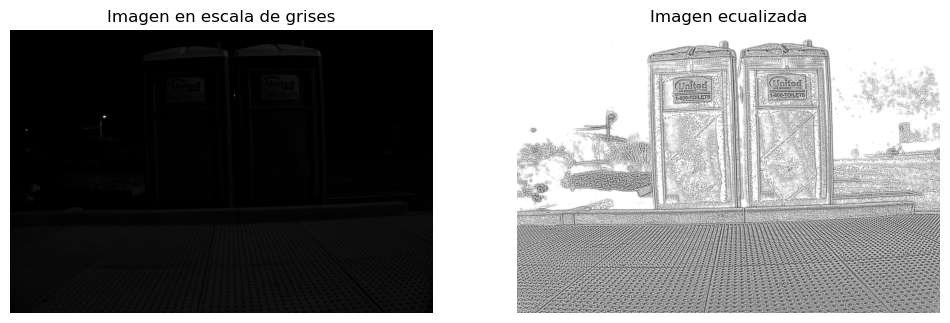

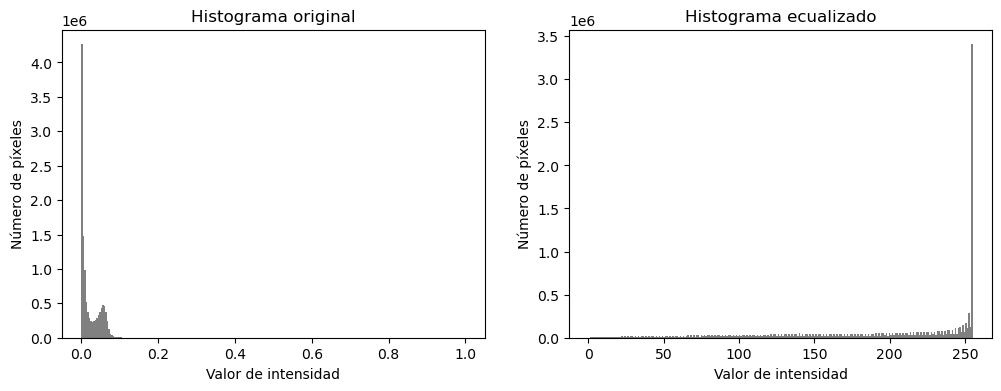

In [12]:
# Convertir a escala de grises
img_gray = rgb2gray(img)

# Crear footprint (elemento estructurante)
footprint = np.ones((20, 20))

# Aplicar ecualización adaptativa
img_eq = filters.rank.equalize(img_gray, footprint=footprint)

# Mostrar valores
print("Valores originales (0-1):")
print("Mínimo:", np.min(img_gray))
print("Máximo:", np.max(img_gray))
print("Media:", np.mean(img_gray))
print("\nValores ecualizados (0-1):")
print("Mínimo:", np.min(img_eq))
print("Máximo:", np.max(img_eq))
print("Media:", np.mean(img_eq))

# Mostrar resultados
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img_gray, cmap='gray')
plt.title('Imagen en escala de grises')
plt.axis('off')

plt.subplot(122)
plt.imshow(img_eq, cmap='gray')
plt.title('Imagen ecualizada')
plt.axis('off')
plt.show()

# Mostrar histogramas
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(img_gray.flatten(), bins=256, color='gray')
plt.title('Histograma original')
plt.xlabel('Valor de intensidad')
plt.ylabel('Número de píxeles')

plt.subplot(122)
plt.hist(img_eq.flatten(), bins=256, color='gray')
plt.title('Histograma ecualizado')
plt.xlabel('Valor de intensidad')
plt.ylabel('Número de píxeles')
plt.show()

### Análisis del Histograma Ecualizado

El histograma de la imagen ecualizada muestra una distribución más uniforme de los valores de intensidad. El rango de valores se expande desde 0 hasta 255, y la media de la imagen ecualizada es significativamente mayor que la original. Los valores más oscuros se han aclarado y los valores más claros se han intensificado, resultando en una distribución más equilibrada que mejora la visibilidad general de la imagen.



### Detección de Bordes

Se aplica el filtro de Sobel a la imagen ecualizada para detectar los bordes presentes en la imagen. El operador de Sobel calcula el gradiente de la imagen, identificando las transiciones de intensidad que corresponden a los bordes de los objetos.



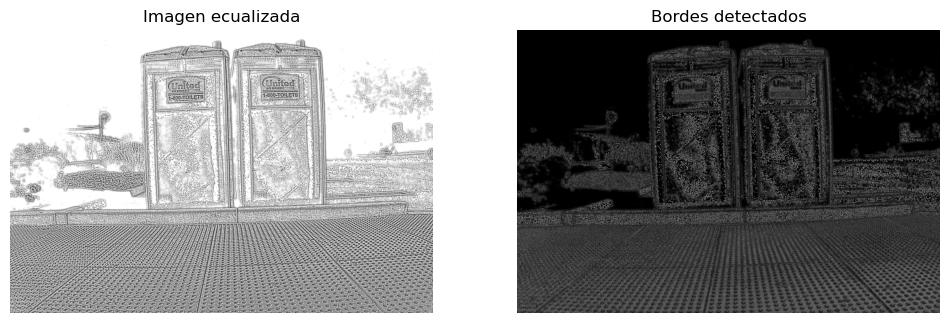

In [14]:
# Obtener imagen de bordes usando el filtro de Sobel
edges = filters.sobel(img_eq)

# Mostrar resultados
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img_eq, cmap='gray')
plt.title('Imagen ecualizada')
plt.axis('off')

plt.subplot(122)
plt.imshow(edges, cmap='gray')
plt.title('Bordes detectados')
plt.axis('off')
plt.show()

### Optimización de la Detección de Bordes

Para mejorar la detección de bordes, se aplican técnicas adicionales de preprocesamiento. Se utiliza un filtro Gaussiano para reducir el ruido antes de la detección de bordes, y se implementa el operador de Canny, que es más robusto que Sobel al proporcionar mejor supresión de no-máximos y detección de bordes más precisos mediante el ajuste de umbrales.



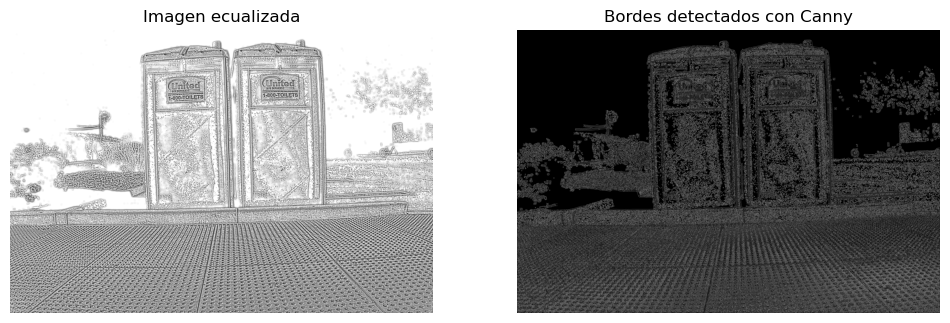

In [15]:
from skimage.filters import gaussian
from skimage.feature import canny

# 1. Reducir ruido con filtro Gaussiano
img_smooth = gaussian(img_eq, sigma=1)

# 2. Aplicar detector de bordes Canny
edges_canny = canny(img_smooth, sigma=1)

# 3. Mostrar resultados
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(img_eq, cmap='gray')
plt.title('Imagen ecualizada')
plt.axis('off')

plt.subplot(122)
plt.imshow(edges_canny, cmap='gray')
plt.title('Bordes detectados con Canny')
plt.axis('off')
plt.show()

In [ ]:
### Comparación de Técnicas de Ecualización

Se compara la ecualización global con la ecualización adaptativa para determinar cuál proporciona mejores resultados en imágenes nocturnas. La ecualización global redistribuye las intensidades de toda la imagen de manera uniforme, mientras que la adaptativa lo hace de manera local.

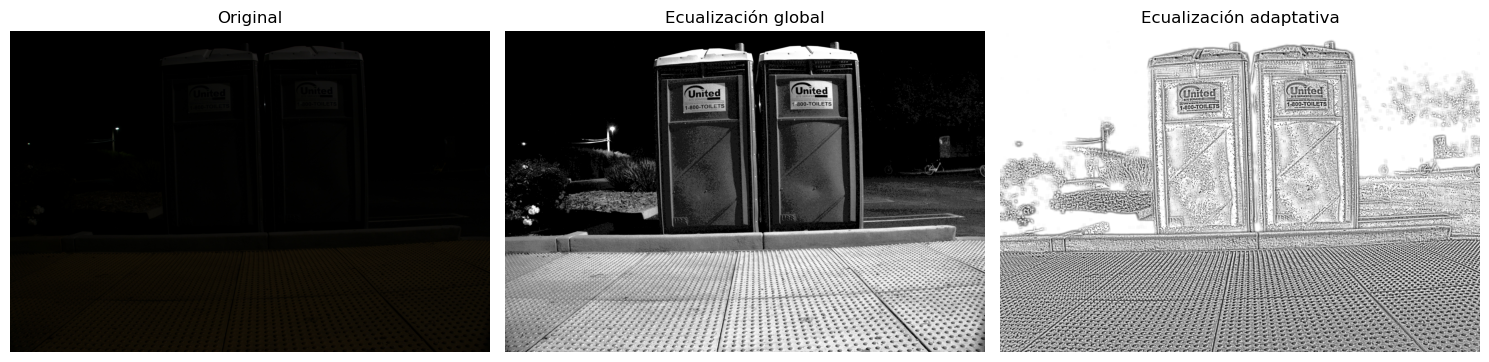

In [18]:
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import binary_dilation, disk
from skimage.feature import canny
from skimage import exposure

# 1. Convertir a escala de grises
img_gray = rgb2gray(img)

# 2. Aplicar ecualización global
img_eq_global = exposure.equalize_hist(img_gray)

# 3. Aplicar ecualización adaptativa
footprint = np.ones((30, 30))
img_eq_adapt = filters.rank.equalize(img_gray, footprint=footprint)

# 4. Resto del pipeline igual para ambas imágenes
threshold = threshold_otsu(img_eq_adapt)
binary = img_eq_adapt > threshold
smoothed = gaussian(binary, sigma=1.5)
edges = canny(smoothed, sigma=1.5)
dilated_edges = binary_dilation(edges, disk(1))

# Mostrar resultados comparativos
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(232)
plt.imshow(img_eq_global, cmap='gray')
plt.title('Ecualización global')
plt.axis('off')

plt.subplot(233)
plt.imshow(img_eq_adapt, cmap='gray')
plt.title('Ecualización adaptativa')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
### Resultados de la Comparación

Aunque inicialmente se podría esperar que la ecualización adaptativa fuera superior para imágenes nocturnas debido a su capacidad de ajuste local, en este caso específico la ecualización global proporciona resultados significativamente mejores, mejorando el contraste general de manera más efectiva.

### Pipeline Completo de Procesamiento

Se implementa un pipeline completo para el procesamiento de imágenes nocturnas y la detección de bordes. El pipeline integra los pasos de preprocesamiento, mejora de contraste, reducción de ruido, segmentación y detección de bordes de manera secuencial para obtener resultados óptimos.



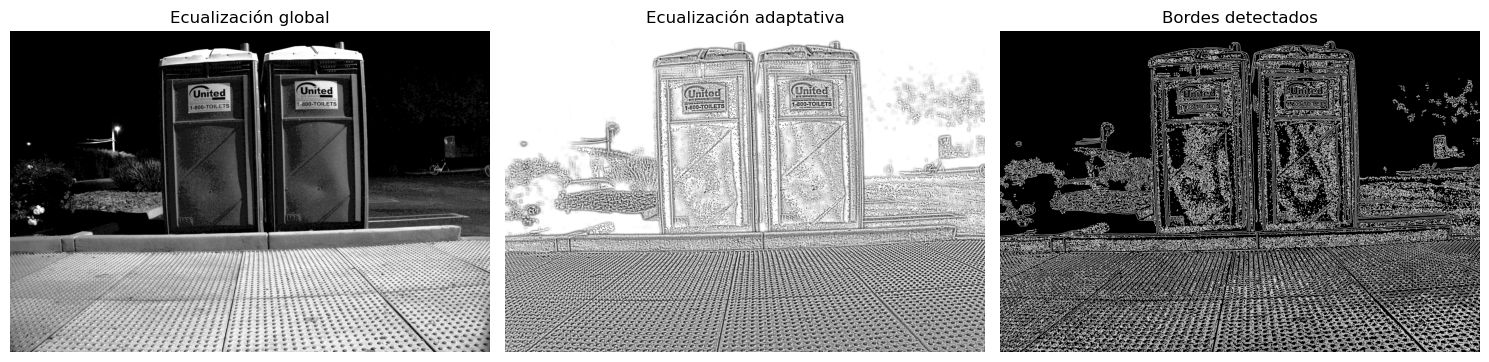

In [ ]:
def pipeline_procesamiento(img):
    """
    Pipeline completo para procesamiento de imágenes nocturnas y detección de bordes.
    
    El pipeline incluye: conversión a escala de grises, ecualización de histograma,
    reducción de ruido, segmentación mediante umbralización de Otsu, detección de bordes
    con Canny y mejora mediante operaciones morfológicas.
    """
    # Preprocesamiento básico: conversión a escala de grises
    img_gray = rgb2gray(img)
    
    # Mejora de contraste: comparación de ecualización global vs adaptativa
    img_eq_global = exposure.equalize_hist(img_gray)
    footprint = np.ones((30, 30))
    img_eq_adapt = filters.rank.equalize(img_gray, footprint=footprint)
    
    # Reducción de ruido mediante filtro Gaussiano
    img_smooth = gaussian(img_eq_adapt, sigma=1.5)
    
    # Segmentación mediante umbralización adaptativa de Otsu
    threshold = threshold_otsu(img_smooth)
    binary = img_smooth > threshold
    
    # Detección de bordes utilizando el operador de Canny con parámetros optimizados
    edges = canny(binary, sigma=1.5)
    
    # Mejora de bordes mediante operaciones morfológicas de dilatación
    edges_final = binary_dilation(edges, disk(1))
    
    return img_eq_global, img_eq_adapt, edges_final

# Ejecutar el pipeline
img_eq_global, img_eq_adapt, edges_final = pipeline_procesamiento(img)

# Mostrar resultados comparativos
plt.figure(figsize=(15, 10))

plt.subplot(131)
plt.imshow(img_eq_global, cmap='gray')
plt.title('Ecualización global')
plt.axis('off')

plt.subplot(132)
plt.imshow(img_eq_adapt, cmap='gray')
plt.title('Ecualización adaptativa')
plt.axis('off')

plt.subplot(133)
plt.imshow(edges_final, cmap='gray')
plt.title('Bordes detectados')
plt.axis('off')

plt.tight_layout()
plt.show()